In [1]:
# install "missing" packages
!pip install -q --upgrade torchmetrics
!pip install -q --upgrade pytorch-lightning
!pip install -q --upgrade opendatasets
!pip install -q --upgrade torchsummary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.2/721.2 kB 11.7 MB/s eta 0:00:00


In [2]:
import os, sys, platform
import warnings
import pathlib
import logging
import logging.config

if sys.version_info < (3, 2,):
    raise ValueError(
        f"{__file__} required Python version >= 3.2. You are using Python "
        f"{platform.python_version}")

#@see: https://colab.research.google.com/drive/1srw_HFWQ2SMgmWIawucXfusGzrj1_U0q

# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
gdrive_mount_point = '/content/drive/'
drive.mount(gdrive_mount_point)
grive_path = os.path.join(gdrive_mount_point, "My Drive/")
print('Your Google Drive is mounted at ', grive_path)

# this path has been copied from the left folder view
colab_notebook_loc = "/content/drive/MyDrive/Colab Notebooks/Pytorch/pyt_lightning/histopat_resnet50"
BASE_PATH = pathlib.Path(colab_notebook_loc).parent

# append base path as well as colab notebook path to Python's sys.path, so we can
# import our custom modules from these locations
sys.path.append(str(BASE_PATH))
sys.path.append(colab_notebook_loc)
print(f"sys.path: {sys.path}")
MODEL_SAVE_DIR = pathlib.Path(colab_notebook_loc) / "model_state"

if not MODEL_SAVE_DIR.exists():
    MODEL_SAVE_DIR.mkdir(parents=True, exist_ok=True)
    # os.mkdir(MODEL_SAVE_DIR)

assert MODEL_SAVE_DIR.exists(), f"FATAL ERROR: oops, unable to create {str(MODEL_SAVE_DIR)}"
print(f"Model state will be saved to {str(MODEL_SAVE_DIR)}")

warnings.filterwarnings("ignore")
logging.config.fileConfig(fname=BASE_PATH / "logging.config")

Mounted at /content/drive/
Your Google Drive is mounted at  /content/drive/My Drive/
sys.path: ['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/MyDrive/Colab Notebooks/Pytorch/pyt_lightning', '/content/drive/MyDrive/Colab Notebooks/Pytorch/pyt_lightning/histopat_resnet50']
Model state will be saved to /content/drive/MyDrive/Colab Notebooks/Pytorch/pyt_lightning/histopat_resnet50/model_state


## Dataset implementation

In [3]:
import os, pathlib, shutil
import opendatasets as od
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import pytorch_lightning as pl
import torchsummary

# my utility functions
from utils import save_model, load_model, predict_module, predict_array
from metrics_logger import MetricsLogger

SEED = pl.seed_everything()

logger = logging.getLogger(__name__)

logger.info(f"Using Pytorch version: {torch.__version__}")
logger.info(f"Using Pytorch Lightning version: {pl.__version__}")

# tweaks for libraries
plt.style.use("seaborn")
sns.set(style="whitegrid", font_scale=1.1, palette="muted")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# NOTE: using the same folder for data as used in the histopat example
TMP_PATH = pathlib.Path("/tmp")
DATA_FILE_PATH = TMP_PATH / "histopat" / "data"
MODEL_STATE_NAME = "pyt_histo_resnet50.pth"
MODEL_STATE_PATH = TMP_PATH / "model_state" / MODEL_STATE_NAME
IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS, NUM_CLASSES = 224, 224, 3, 2

logger.info(f"Training model on {DEVICE}")
logger.info(f"Using data file in path {DATA_FILE_PATH}")

from histo_dataset import get_datasets, display_sample, plot_confusion_matrix
from histo_model_resnet50 import HistoCancerModelResnet50

numexpr.utils - INFO - NumExpr defaulting to 4 threads.
torch.distributed.nn.jit.instantiator - INFO - Created a temporary directory at /tmp/tmpr6c_82lk
torch.distributed.nn.jit.instantiator - INFO - Writing /tmp/tmpr6c_82lk/_remote_module_non_scriptable.py
lightning_fabric.utilities.seed - INFO - Global seed set to 873586107
__main__ - INFO - Using Pytorch version: 2.0.1+cu118
__main__ - INFO - Using Pytorch Lightning version: 2.0.4
__main__ - INFO - Training model on cuda
__main__ - INFO - Using data file in path /tmp/histopat/data


In [4]:
print(f"Data folder: {DATA_FILE_PATH}")
if not DATA_FILE_PATH.exists():
    DATA_FILE_PATH.mkdir(parents=True, exist_ok=True)
assert pathlib.Path(DATA_FILE_PATH).exists(), f"FATAL: Data path {DATA_FILE_PATH} does not exist!"

Data folder: /tmp/histopat/data


<font color="salmon">**NOTE**: Follow code cell will take a loo...oong time to complete!</font> Please remain calm & get a coffee or 2.

In [6]:
num_benign, num_malignant, train_dataset, val_dataset, test_dataset = get_datasets(
    DATA_FILE_PATH, force_download=False, force_recreate=False, random_state=SEED,
)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mjbhobe
Your Kaggle Key: ··········


100%|██████████| 6.31G/6.31G [00:50<00:00, 133MB/s]



Extracting archive /tmp/histopat/data/histopathologic-cancer-detection/histopathologic-cancer-detection.zip to /tmp/histopat/data/histopathologic-cancer-detection
histo_dataset - INFO - Trying to split data into 52500 training, 15000 cross-val and 7500 testing records
histo_dataset - INFO - Sample sizes -> train: 52500 - eval: 15000 - test: 7500
histo_dataset - INFO - Creating train images


Creating train images: 100%|██████████| 52500/52500 [10:37<00:00, 82.40it/s, Copying=127fcde4ba46b6f2c02e936732c94754be58450d.tif]

histo_dataset - INFO - Creating eval images



Creating eval images: 100%|██████████| 15000/15000 [03:01<00:00, 82.52it/s, Copying=54299a4ea4295d1236f32b381d1d91e15626c3ff.tif]

histo_dataset - INFO - Creating test images



Creating test images: 100%|██████████| 7500/7500 [01:30<00:00, 82.60it/s, Copying=43696e156ab4510d69d2ff0ea54913fdb192085b.tif]


histo_dataset - INFO - Training images -> benign: 31236 - malignant: 21264 - total: 52500
histo_dataset - INFO - Cross-val images -> benign: 8925 - malignant: 6075 - total: 15000
histo_dataset - INFO - Test images -> benign: 4462 - malignant: 3038 - total: 7500


Training on 52,500 training, 15,000 cross-validation and 7,500 test records

In [7]:
NUM_EPOCHS, BATCH_SIZE, LR = 50, 64, 0.001

In [8]:
print(f"Label counts -> num_benign: {num_benign} - num_malignant: {num_malignant}")

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
)

Label counts -> num_benign: 4462 - num_malignant: 3038


Displaying random sample from test dataset


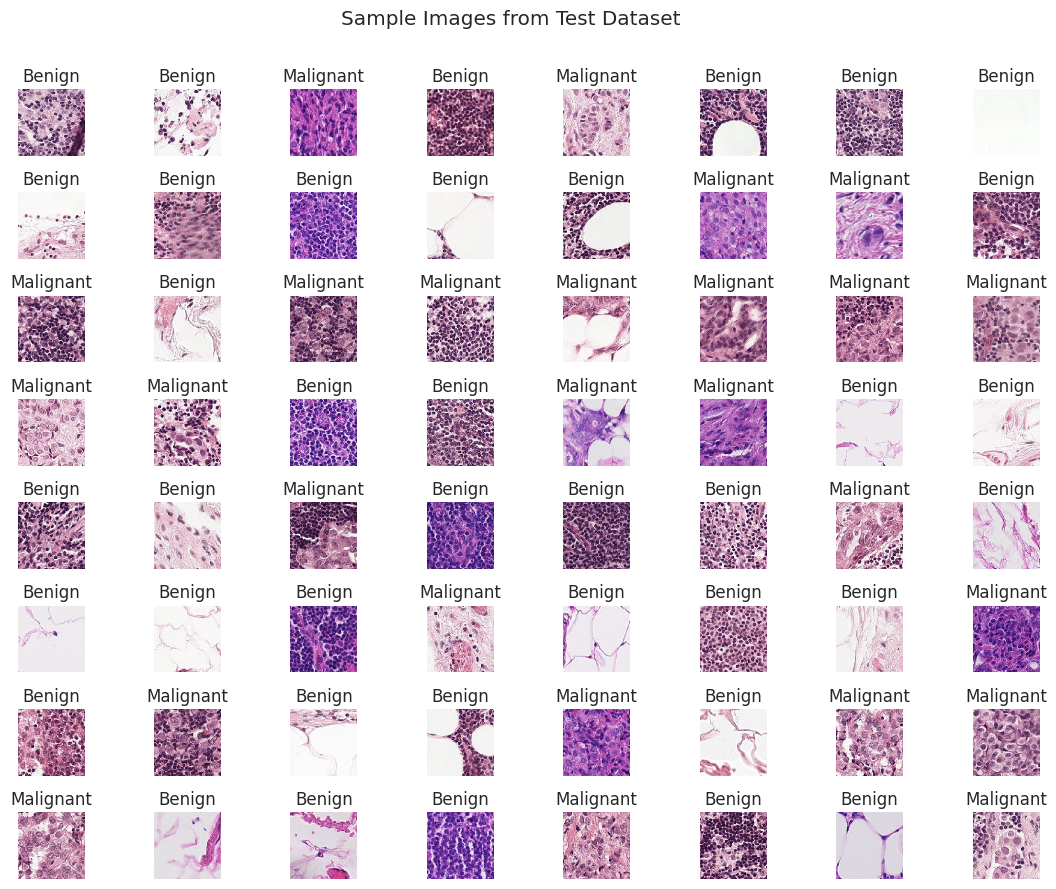

In [9]:
# display sample from test dataset
print("Displaying random sample from test dataset")
data_iter = iter(test_loader)
# fetch first batch of 64 images & labels
images, labels = next(data_iter)
display_sample(
    images[:BATCH_SIZE].cpu().numpy(),
    labels[:BATCH_SIZE].cpu().numpy(),
    grid_shape=(8, 8),
    plot_title="Sample Images from Test Dataset",
)

## Training the model

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 135MB/s]


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Pytorch model saved to /tmp/model_state/pyt_histo_resnet50.pth


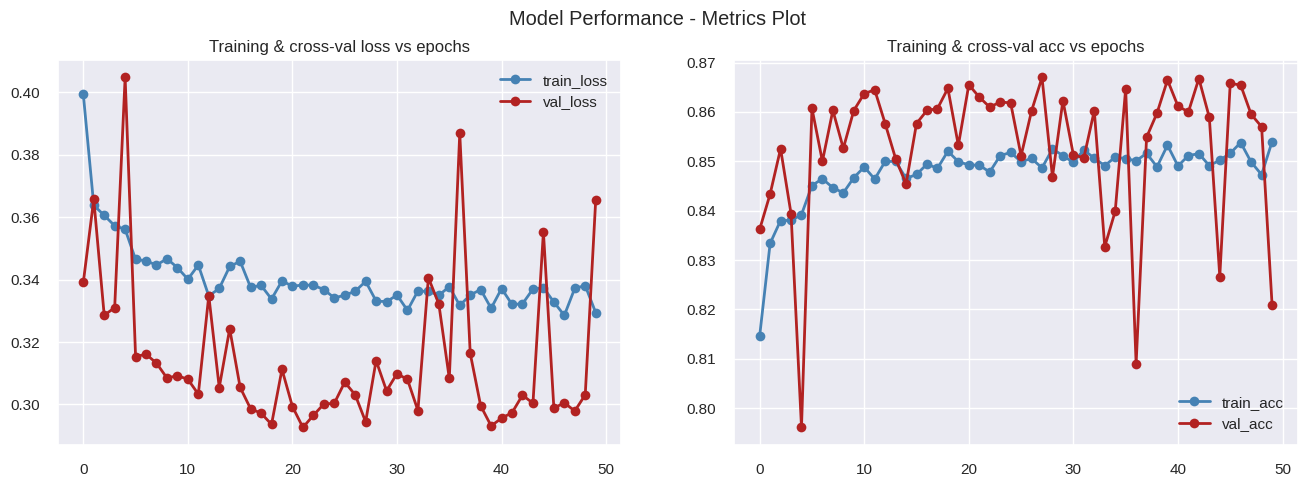

In [10]:
model = HistoCancerModelResnet50(
    num_benign,
    num_malignant,
    NUM_CHANNELS,
    NUM_CLASSES,
    LR,
    # weighted_loss=True
)
#print(torchsummary.summary(model, (NUM_CHANNELS, IMAGE_HEIGHT, IMAGE_WIDTH)))

metrics_history = MetricsLogger()
trainer = pl.Trainer(
    max_epochs=NUM_EPOCHS,
    logger=metrics_history,
)
trainer.fit(
    model,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader,
)
import pickle

with open("metrics_hist.pkl", "wb") as pf:
    pickle.dump(metrics_history.history, pf)
save_model(model, MODEL_STATE_PATH)
metrics_history.plot_metrics(title="Model Performance - Metrics Plot")
del model

In [11]:
# evaluate model performance
model = HistoCancerModelResnet50(
    num_benign,
    num_malignant,
    NUM_CHANNELS,
    NUM_CLASSES,
    LR,
    # weighted_loss=True
)
model = load_model(model, MODEL_STATE_PATH)
# print(torchsummary.summary(model, (NUM_CHANNELS, IMAGE_HEIGHT, IMAGE_WIDTH)))

# run a validation on Model
trainer = pl.Trainer()
print(f"Validating on train-dateset...")
trainer.validate(model, dataloaders=train_loader)
print(f"Validating on val-dateset...")
trainer.validate(model, dataloaders=val_loader)
print(f"Validating on test-dateset...")
trainer.validate(model, dataloaders=test_loader)

del model

Pytorch model loaded from /tmp/model_state/pyt_histo_resnet50.pth
Validating on train-dateset...


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8197932243347168     │
│         val_loss          │     0.355873703956604     │
└───────────────────────────┴───────────────────────────┘

Validating on val-dateset...


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │     0.821721076965332     │
│         val_loss          │    0.3653949797153473     │
└───────────────────────────┴───────────────────────────┘

Validating on test-dateset...


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8198285698890686     │
│         val_loss          │    0.36286139488220215    │
└───────────────────────────┴───────────────────────────┘

### Observations
Training on 52,500 training, 15,000 cross-validation and 7,500 test records:
>Configuration | Training Acc | Cross-val Acc | Test Acc | Observation
>:---|:---:|:---:|:---:|:---|
>**Model #1 - Epochs=50, Batch Size=64, LR=0.001 (unweighted loss)**|81.98%|82.17%|81.98%| Slightly underfitting (can do much better)
>**Model #2 - Epochs=50, Batch Size=64, LR=0.001, (weighted loss)**|87.15%|87.32%|87.30| Better performance, no overfitting.

Both models are doing reasonably well; neither is significantly over or underfitting. We'll get a better picture in confusion matrix.

Pytorch model loaded from /tmp/model_state/pyt_histo_resnet50.pth
Sample labels (50):  [1 0 1 1 1 1 0 0 0 1 1 1 1 1 0 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0
 1 0 1 0 1 1 0 1 0 1 0 1 1]
Sample predictions:  [1 0 1 0 1 1 0 0 0 1 1 0 0 1 0 1 1 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0
 1 0 1 0 0 0 0 1 0 1 0 1 1]
We got 1120/7500 incorrect!
Confusion Matrix


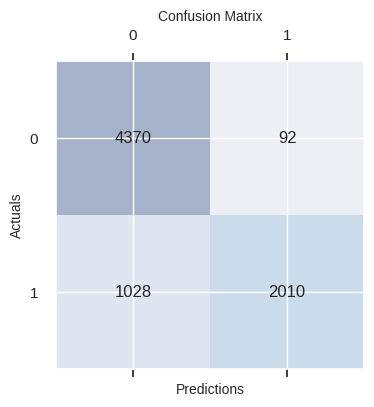

In [12]:
# predictions
model = HistoCancerModelResnet50(
    num_benign,
    num_malignant,
    NUM_CHANNELS,
    NUM_CLASSES,
    LR,
    # weighted_loss=True
)
model = load_model(model, MODEL_STATE_PATH)
# print(torchsummary.summary(model, (NUM_CHANNELS, IMAGE_HEIGHT, IMAGE_WIDTH)))

# predict from test_dataset
preds, actuals = predict_module(model, test_loader, DEVICE)
preds = np.argmax(preds, axis=1)
print("Sample labels (50): ", actuals[:50])
print("Sample predictions: ", preds[:50])
print("We got %d/%d incorrect!" % ((preds != actuals).sum(), len(actuals)))

print("Confusion Matrix")
from sklearn.metrics import confusion_matrix
plot_confusion_matrix(confusion_matrix(actuals, preds))

* **Model #1** - Model is predicting a lot (1024!) False Negatives, but relative less (92) False Positives, which is a concern. This means that 1024 patients from test set were told they don't have Cancer when they actually did!
* **Model #2** - Model is predicting 457 False Negatives (False positives have naturally increased to 468 from 92). This model is doing much better than previous one. However, 457 False Negatives is still a concern.

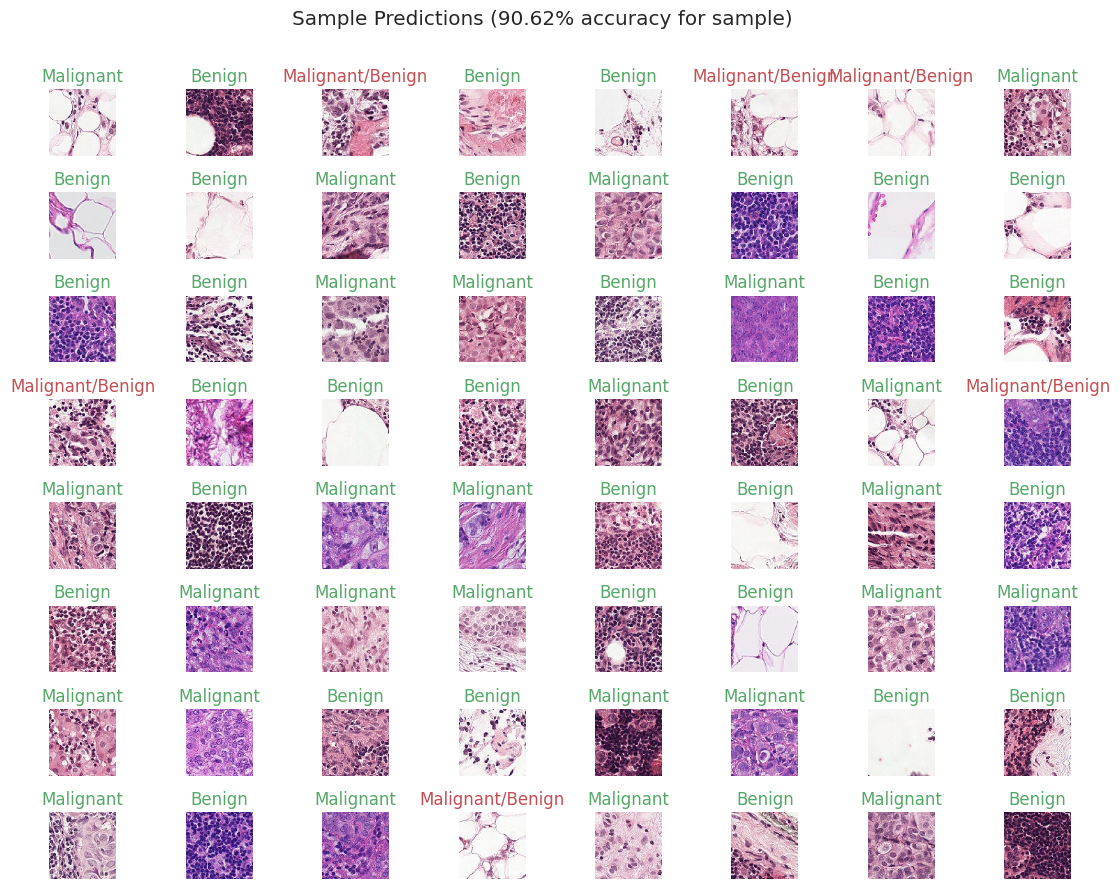

In [13]:
# display sample predictions
data_iter = iter(test_loader)
images, labels = next(data_iter)
preds, actuals = predict_module(
    model,
    (images.cpu().numpy(), labels.cpu().numpy()),
    DEVICE,
    num_iters=1,
)
preds = np.argmax(preds, axis=1)
accu = (preds == actuals).sum() / len(actuals)
display_sample(
    images.cpu().numpy()[:64],
    actuals[:64],
    sample_predictions=preds[:64],
    grid_shape=(8, 8),
    plot_title=f"Sample Predictions ({accu * 100:.2f}% accuracy for sample)",
)

In [14]:
del model

<center><h1> * - * - FIN/END - * - * </h1></center>